## Week 6 notebook

Include concepts such as decision trees and random forests on your datasets

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns

# Import feature engineering and selection libraries
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

# data preprocesing
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Classification metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, f1_score, classification_report

# Regression metrics
from sklearn.metrics import root_mean_squared_error, r2_score

random_state = 0

In [2]:
# encode categorical features
def encode_categories(df: pd.DataFrame):
    df_encoded = df.copy()
    mappings = {}
    cat_cols = df_encoded.select_dtypes(include=['object', 'category']).columns.tolist()
    
    for col in cat_cols:
        # get the unique categories (in order of appearance)
        uniques = df_encoded[col].dropna().unique().tolist()
        # build a mapping: category -> code
        mapping = {cat: code for code, cat in enumerate(uniques)}
        mappings[col] = mapping

        # map (leave NaN as NaN)
        df_encoded[col] = df_encoded[col].map(mapping).astype("int64")

    return df_encoded, mappings

In [3]:
# # Create a function to load and split data
# def load_and_split_data(file_path, test_size=0.2, target_col: str = None, random_state=random_state, choice='norm'):

#     # Read and Encode catigorical features
#     df = pd.read_csv(file_path)
#     df_encoded, _ = encode_categories(pd.read_csv(file_path))

#     if target_col is None:
#         target_col = df_encoded.columns[-1]
#     X = df_encoded.drop(columns=[target_col])
#     y = df_encoded[target_col]

#     # Train and test split
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

#     # reshaye y to 1D array
#     y_train = y_train.values.ravel()
#     y_test = y_test.values.ravel()

#     if choice == 'reg':
#         # Regularize the features
#         scaler = StandardScaler()
#         X_train_scaled = scaler.fit_transform(X_train)
#         X_test_scaled = scaler.transform(X_test)

#         # Convert scaled features back to DataFrames
#         X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
#         X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train.columns)

#     else:
#         # Bormalize the features
#         scaler = MinMaxScaler()
#         X_train_scaled = scaler.fit_transform(X_train)
#         X_test_scaled = scaler.transform(X_test)

#         # Convert scaled features back to DataFrames
#         X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
#         X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train.columns)

#     return X_train_scaled, X_test_scaled, y_train, y_test, df

In [4]:
def load_and_split_data(
    file_path: str,
    target_col: str = None,
    test_size: float = 0.2,
    random_state: int = 0,
    scaling: str = 'norm'
):
    """
    Loads data, encodes categorical features, splits into train/test, and scales features.

    Args:
        file_path: Path to CSV file.
        target_col: Name of target column. If None, uses last column.
        test_size: Fraction for test split.
        random_state: Random seed.
        scaling: 'norm' (MinMax), 'reg' (Standard), or None.

    Returns:
        X_train, X_test, y_train, y_test, df_encoded, mappings
    """
    df = pd.read_csv(file_path)
    df_encoded, mappings = encode_categories(df)

    # Select target
    if target_col is None:
        target_col = df_encoded.columns[-1]
    X = df_encoded.drop(columns=[target_col])
    y = df_encoded[target_col]

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Reset indices
    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    # Scaling
    if scaling == 'reg':
        scaler = StandardScaler()
    elif scaling == 'norm':
        scaler = MinMaxScaler()
    else:
        scaler = None

    if scaler is not None:
        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
        X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

    return X_train, X_test, y_train, y_test, df_encoded, mappings


In [5]:
def gridsearchcv(model, X_train, y_train, param_dict=None, random_state=random_state, scoring='accuracy', cv=None):
    """
    Generic grid search function for any sklearn model and parameter grid.

    Args:
        model: The sklearn model class (not an instance), e.g., SVC, RandomForestClassifier, etc.
        X_train: Training features.
        y_train: Training target.
        param_dict: Dictionary of parameter grid for the model.
        random_state: Random state for reproducibility.
        scoring: Scoring metric for GridSearchCV.
        cv: Cross-validation strategy (optional).

    Returns:
        grid_best_params: Best parameter dictionary.
        grid_cv_score: Best cross-validated score.
    """
    # If the model supports random_state, pass it; otherwise, ignore
    try:
        base_model = model(random_state=random_state)
    except TypeError:
        base_model = model()

    # Use provided cv or default to RepeatedStratifiedKFold for classification
    if cv is None:
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=random_state)

    search = GridSearchCV(
        estimator=base_model,
        param_grid=param_dict,
        scoring=scoring,
        cv=cv,
        n_jobs=-1,
        return_train_score=True,
        error_score='raise'
    )

    search.fit(X_train, y_train)

    # Extract results into a DataFrame
    results = pd.DataFrame(search.cv_results_)

    # Print top 5 results (show all param columns dynamically)
    param_cols = [col for col in results.columns if col.startswith('param_')]
    display_cols = param_cols + [
        'mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score', 'rank_test_score'
    ]
    results = results[display_cols].sort_values(by='rank_test_score')
    renamed_results = results.rename(
        columns={col: col.replace('param_', '') for col in param_cols} |
                {'mean_test_score': 'mean_cv_score', 'std_test_score': 'std_cv_score'}
    ).drop(columns=['rank_test_score'])

    print("\nSearch Results (Top 5):\n")
    print(renamed_results.head(5).to_string(index=False))

    # Best parameters and test performance
    grid_best_params = search.best_params_
    print(f"\nBest Parameters: {grid_best_params}")
    grid_cv_score = search.best_score_
    print(f"Best CV Score: {grid_cv_score:.4f}")

    return grid_best_params, grid_cv_score

In [6]:
# Load the ins claims dataset
X_train_ins_reg, X_test_ins_reg, y_train_ins_reg, y_test_ins_reg, df_ins_reg, ins_reg_mappings = load_and_split_data(r'C:\Users\JT von Seggern\DS Masters Repos\2025-spring-B2\data\insurance_claims_cleaned.csv', scaling='reg')

In [7]:
# Run Grid search on the ins claims dataset
rf_ins_params = {
    'n_estimators': [10, 50, 100, 200, 500, 1000],
    'max_depth': range(3,20),
    'min_samples_split': range(2,5)
}

ins_reg_rf_grid_best_params, ins_reg_rf_grid_cv_score = gridsearchcv(
    RandomForestClassifier, X_train_ins_reg, y_train_ins_reg, param_dict=rf_ins_params, scoring='accuracy')


Search Results (Top 5):

 max_depth  min_samples_split  n_estimators  mean_cv_score  std_cv_score  mean_train_score  std_train_score
         7                  2            10         0.7850      0.024622          0.937438         0.008609
         8                  3            10         0.7850      0.018456          0.955937         0.007395
         9                  4            10         0.7835      0.020982          0.963938         0.008915
         4                  4            10         0.7830      0.019487          0.839688         0.013954
         9                  3            10         0.7815      0.019802          0.970438         0.007354

Best Parameters: {'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 10}
Best CV Score: 0.7850


In [17]:
# Run Grid search on the ins claims dataset
dt_ins_params = {
    'max_depth': range(3,20),
    'min_samples_split': range(2,10)
}

ins_reg_dt_grid_best_params, ins_reg_dt_grid_cv_score = gridsearchcv(
    DecisionTreeClassifier, X_train_ins_reg, y_train_ins_reg, param_dict=dt_ins_params, scoring='accuracy')


Search Results (Top 5):

 max_depth  min_samples_split  mean_cv_score  std_cv_score  mean_train_score  std_train_score
         5                  3        0.84075      0.028069          0.922250         0.008020
         5                  4        0.84050      0.028069          0.922188         0.008077
         5                  5        0.84050      0.028069          0.922125         0.008145
         5                  2        0.84025      0.027955          0.922875         0.008063
         5                  6        0.83975      0.027776          0.921875         0.008101

Best Parameters: {'max_depth': 5, 'min_samples_split': 3}
Best CV Score: 0.8407


In [33]:
def classifier_model(model_class, X_train, y_train, X_test, y_test, random_state=random_state, **model_params):
    """
    Generic function to fit and evaluate any sklearn classifier model.

    Args:
        model_class: The sklearn classifier class (e.g., RandomForestClassifier, DecisionTreeClassifier).
        X_train, y_train: Training data.
        X_test, y_test: Test data.
        model_params: Parameters for the classifier.

    Prints:
        Classification report, accuracy, F1 score, and confusion matrix plot.

    Returns:
        model: The fitted model.
        y_pred: The predictions on X_test.
    """
    model = model_class(random_state=random_state, **model_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    clf_name = model_class.__name__

    # Print the classification report
    report = classification_report(y_test, y_pred, output_dict=False)
    print(f"Classification Report for {clf_name}:")
    print(report)
    print("\n")

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{clf_name} Accuracy: {accuracy:.2f}")
    
    # Calculate f1 score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"{clf_name} F1 score: {f1:.2f}")
    
    # Plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {clf_name}')
    plt.tight_layout()
    plt.show()

Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.76      0.95      0.85       143
           1       0.68      0.26      0.38        57

    accuracy                           0.76       200
   macro avg       0.72      0.61      0.61       200
weighted avg       0.74      0.76      0.71       200



RandomForestClassifier Accuracy: 0.76
RandomForestClassifier F1 score: 0.71


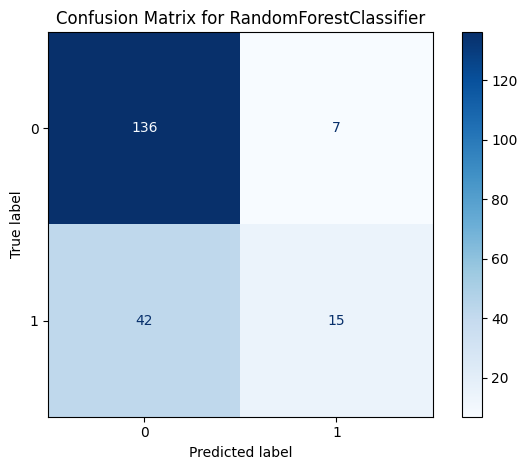

In [39]:
# run evaluation on the ins dataset
classifier_model(RandomForestClassifier, X_train_ins_reg, y_train_ins_reg, X_test_ins_reg, y_test_ins_reg, **ins_reg_rf_grid_best_params)

Classification Report for DecisionTreeClassifier:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87       143
           1       0.71      0.56      0.63        57

    accuracy                           0.81       200
   macro avg       0.77      0.74      0.75       200
weighted avg       0.80      0.81      0.80       200



DecisionTreeClassifier Accuracy: 0.81
DecisionTreeClassifier F1 score: 0.80


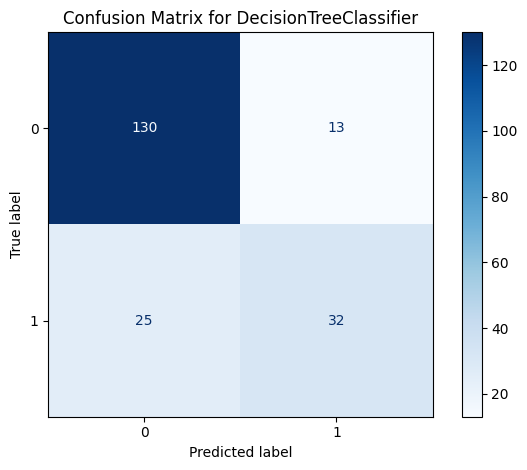

In [43]:
# run evaluation on the ins dataset
classifier_model(DecisionTreeClassifier, X_train_ins_reg, y_train_ins_reg, X_test_ins_reg, y_test_ins_reg, **ins_reg_dt_grid_best_params)